In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
import numpy as np
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.utils import *
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train = x_train.astype('float32')
x_train = np.reshape(x_train, (x_train.shape[0], 28*28))
x_test = x_test.astype('float32')
x_test = np.reshape(x_test, (x_test.shape[0], 28*28))

In [ ]:
x_train = x_train / 255.0
x_test = x_test / 255.0

In [ ]:
def createModel():
  num_classes = 10

  model = models.Sequential()
  model.add(layers.Dense(900, activation='relu', input_shape=(784,)))
  model.add(layers.Dense(600, activation='relu'))
  model.add(layers.Dense(300, activation='relu'))
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))

  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
def fitModel(model, x_train, y_train, x_test, y_test):
  batch_size = 64
  epochs = 10
  model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

In [ ]:
def evaluateModel(model, x_test, y_test):
  score = model.evaluate(x_test, y_test, verbose = 0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])
  return score

In [ ]:
class PiLayer(tf.keras.layers.Layer):
    def __init__(self, W, b, activation=None):
        super(PiLayer, self).__init__()
        self.kernel = self.add_weight("kernel", (W.shape[0], W.shape[1]), initializer="glorot_uniform", trainable=False)
        self.bias = self.add_weight("bias", (W.shape[1],), initializer="zeros", trainable=False)
        self.set_weights([W, b])
        self.activation = tf.keras.activations.get(activation)
        self.pi = self.add_weight("pi", (W.shape[0], W.shape[1]), initializer="glorot_uniform", trainable=True)

    def call(self, inputs):
        A = self.kernel * self.pi
        output = tf.matmul(inputs, A) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

In [ ]:
def simpleAttack(model, µ, σ, indexLayer):
  layer = model.layers[indexLayer]
  Wi, _ = layer.get_weights()
  noise = np.random.normal(µ, σ, size=Wi.shape)
  Wi += noise
  layer.set_weights([Wi, _])

In [ ]:
def Attack(model, data, labels, µ, σ, batch_size, epochs):

  if isinstance(model, tf.keras.Sequential):
    model_temp = tf.keras.Sequential()
  else:
      print("The model is not sequential.")

  i = 0
  n = len(model.layers)
  while i < n:
    VictimLayer = model.layers[i]
    wi, bi = VictimLayer.get_weights()
    layer = PiLayer(wi, bi, VictimLayer.activation.__name__)
    if isinstance(layer, tf.keras.layers.Dense):
      model_temp.add(layer)
    else:
      model_temp.add(layer)
    i += 1

  model_temp.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
  model_temp.fit(data, labels, batch_size=batch_size, epochs=epochs)

  max_p = -float('inf')
  layers_to_modify = []
  for j, layer in enumerate(model_temp.layers):
    P = layer.pi
    pj = np.max(np.abs((P.numpy())))
    print(pj, max_p)

    if pj >= max_p:
      if pj > max_p:
        layers_to_modify = []
      max_p = pj
      layers_to_modify.append(j)

  for j in layers_to_modify:
      layer = model.layers[4]
      Wi, _ = layer.get_weights()
      noise = np.random.normal(µ, σ, size=Wi.shape)
      Wi += noise
      layer.set_weights([Wi, _])

In [ ]:
Attack(model, x_train, y_train, 0, 0.1, 128, 10)

Epoch 1/10
469/469 [==============================] - 18s 37ms/step - loss: 1.9166 - accuracy: 0.2376
Epoch 2/10
469/469 [==============================] - 16s 35ms/step - loss: 0.8404 - accuracy: 0.7043
Epoch 3/10
469/469 [==============================] - 16s 35ms/step - loss: 0.4087 - accuracy: 0.8812
Epoch 4/10
469/469 [==============================] - 17s 36ms/step - loss: 0.2828 - accuracy: 0.9209
Epoch 5/10
469/469 [==============================] - 16s 35ms/step - loss: 0.2285 - accuracy: 0.9356
Epoch 6/10
469/469 [==============================] - 16s 34ms/step - loss: 0.1925 - accuracy: 0.9462
Epoch 7/10
469/469 [==============================] - 16s 34ms/step - loss: 0.1665 - accuracy: 0.9541
Epoch 8/10
469/469 [==============================] - 17s 36ms/step - loss: 0.1445 - accuracy: 0.9603
Epoch 9/10
469/469 [==============================] - 16s 34ms/step - loss: 0.1294 - accuracy: 0.9644
Epoch 10/10
469/469 [==============================] - 16s 34ms/step - loss: 0.114

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.09583437442779541
Test accuracy: 0.9807999730110168


In [ ]:
import pandas as pd

def analysis(x_train, x_test, y_train, y_test):
  noises = ["0.1", "0.2", "0.3", "0.4", "0.5"]
  df = pd.DataFrame(columns=noises)
  dictio = {}
  for k in noises:
    print(f"Lets start for {k} \n")
    analysisList = []
    for i in range(4):
      print(f"Round {i+1} \n")
      model = createModel()
      fitModel(model, x_train, y_train, x_test, y_test)
      print("Model evolution aftre attack: \n")
      score = evaluateModel(model, x_test, y_test)
      simpleAttack(model, 0, float(k), i)
      print("Model evolution aftre attack: \n")
      score = evaluateModel(model, x_test, y_test)
      analysisList.append(score[1])
    dictio[k] = analysisList
  new = pd.DataFrame(dictio)
  df = df.append(new, ignore_index=True)
  print("Done!")
  df.to_csv('attackAnalysis.csv', index=False)

In [ ]:
analysis(x_train, x_test, y_train, y_test)

Lets start for 0.1 

Round 1 

Epoch 1/10
938/938 [==============================] - 6s 5ms/step - loss: 0.2026 - accuracy: 0.9386 - val_loss: 0.1106 - val_accuracy: 0.9659
Epoch 2/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0890 - accuracy: 0.9733 - val_loss: 0.1051 - val_accuracy: 0.9693
Epoch 3/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0655 - accuracy: 0.9804 - val_loss: 0.0840 - val_accuracy: 0.9750
Epoch 4/10
938/938 [==============================] - 4s 5ms/step - loss: 0.0485 - accuracy: 0.9848 - val_loss: 0.0824 - val_accuracy: 0.9749
Epoch 5/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0403 - accuracy: 0.9879 - val_loss: 0.0868 - val_accuracy: 0.9764
Epoch 6/10
938/938 [==============================] - 4s 4ms/step - loss: 0.0338 - accuracy: 0.9894 - val_loss: 0.0725 - val_accuracy: 0.9799
Epoch 7/10
938/938 [==============================] - 5s 5ms/step - loss: 0.0295 - accuracy: 0.9913 - val_loss: 0.074

<ipython-input-41-cf9563093cae>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new, ignore_index=True)


In [ ]:
float("0.1")

0.1

In [ ]:
analy

{'0': 0.819100022315979,
 '1': 0.9749000072479248,
 '2': 0.98089998960495,
 '3': 0.9782999753952026}

In [ ]:
df = pd.read_csv("/content/attackAnalysis.csv")

In [ ]:
df

,0.1,0.2,0.3,0.4,0.5
0,0.9616,0.9295,0.6859,0.5786,0.2779
1,0.9781,0.9720,0.9624,0.9024,0.8022
2,0.9746,0.9779,0.9698,0.9713,0.8918
3,0.9773,0.9736,0.9778,0.8905,0.6557


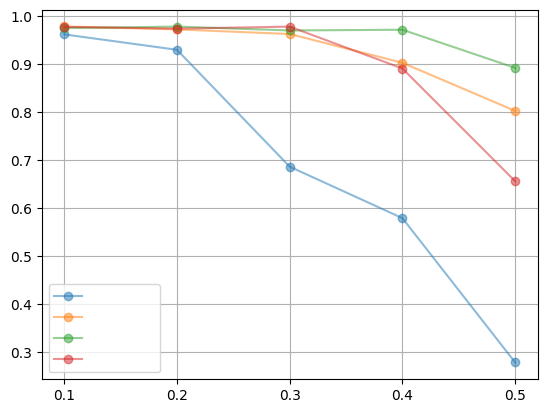

In [ ]:
plt.plot(df.iloc[0], marker='o', label='              ', alpha=0.5)
plt.plot(df.iloc[1], marker='o', label='              ', alpha=0.5)
plt.plot(df.iloc[2], marker='o', label='              ', alpha=0.5)
plt.plot(df.iloc[3], marker='o', label='              ', alpha=0.5)

plt.legend()
plt.grid(True)

plt.savefig('plot.png', transparent=True)

plt.show()